In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
fi_LBM = np.load("fi_LBM_taylor.npy")
fi_2ndCL = np.load("fi_2nd CL_taylor.npy")

TKE_LBM = np.load("fi_LBM_TKE.npy")
TKE_2ndCL = np.load("fi_2nd CL_TKE.npy")

In [3]:
# Configurations
Nx = 16
Ny = 16
Nt = 31

k = 1.0       # wave number
u0 = 0.1      # initial velocity magnitude
omega = 1.0   # relaxation parameter
BGK_nu = 1/3 * (1/omega - 1/2)  # LBM viscosity

ci = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1], 
               [0, 0, 1, 0, -1, 1, 1, -1, -1]])

In [4]:
# Control parameters
A, B = 0.1, -0.1 # Amplitude of velocity components
a, b = 1.0, 1.0  # Wave number

xm = np.linspace(0, 2*np.pi, Nx)
ym = np.linspace(0, 2*np.pi, Ny)
X, Y = np.meshgrid(xm, ym, indexing='ij')

dx = 2 * np.pi / (Nx - 1)
dy = 2 * np.pi / (Ny - 1)

u = A * np.cos(a * X) * np.sin(b * Y) 
v = B * np.sin(a * X) * np.cos(b * Y)

# Analytical solution
TKE_analyical = []
for t in range(Nt):
    t_physical = t * np.pi / 20
    ui = u * np.exp(- 2 * BGK_nu * k**2 * t_physical)
    vi = v * np.exp(- 2 * BGK_nu * k**2 * t_physical)
    
    TKE = 0.5 * (ui**2 + vi**2) * dx * dy # initial density is 1.0
    TKE_analyical.append(np.sum(TKE))

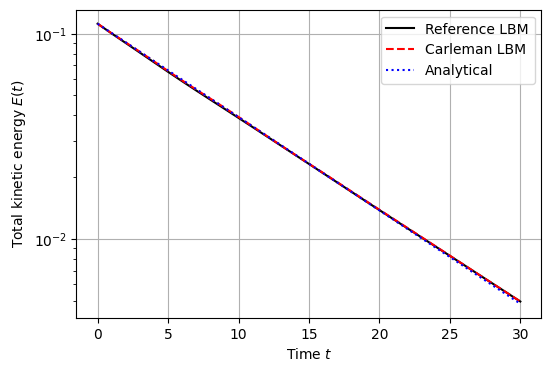

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(TKE_LBM, linestyle='-', color='black', label='Reference LBM')
plt.plot(TKE_2ndCL, linestyle='--', color='red',label='Carleman LBM')
plt.plot(TKE_analyical, linestyle=':', color='blue',label='Analytical')
plt.xlabel('Time $t$')
plt.yscale('log')
plt.ylabel('Total kinetic energy $E(t)$')
plt.grid(True)
plt.legend()
plt.savefig("TG_TKE.pdf", format='pdf')  # Vector export
plt.show()

In [6]:
def get_macro_quantities(fi):
    rho = np.sum(fi, axis=2)  # Density
    ux = np.sum(fi * ci[0], 2) / rho
    uy = np.sum(fi * ci[1], 2) / rho
    
    return rho, ux, uy

def rmse(a, b):
    rmse = np.sqrt(np.mean(((a - b))**2))
    return rmse

def mae(a, b):
    error = np.mean(np.abs(a - b))
    return error

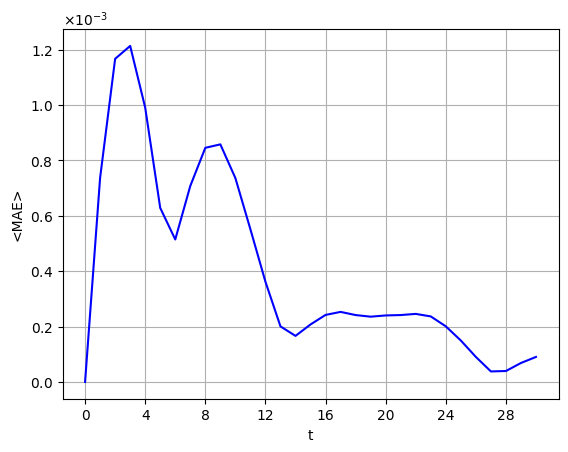

In [7]:
MAEs, AEs = [], []

for t in range(Nt):
    # Compute macro velocity
    _, uxe1t, uye1t = get_macro_quantities(fi_LBM[t])
    umite = np.linalg.norm(np.stack([uxe1t, uye1t]), axis=0)
    
    _, uxc1t, uyc1t = get_macro_quantities(fi_2ndCL[t])
    umitc = np.linalg.norm(np.stack([uxc1t, uyc1t]), axis=0)
    
    # Error data
    maes = mae(umite, umitc)
    MAEs.append(maes)
    
plt.plot(np.arange(Nt), MAEs, color='blue')
plt.xlabel("t")
plt.ylabel("<MAE>")
plt.grid(True)

plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.savefig("TG_MAE_u.pdf", format='pdf')  # Vector export
plt.show()

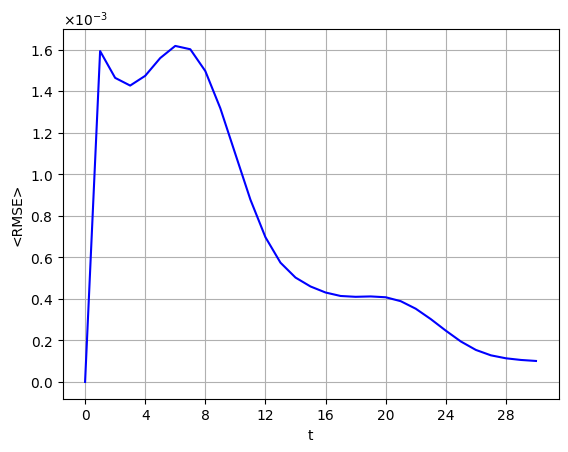

In [8]:
RMSEs = []
for t in range(Nt):
    rmses = rmse(fi_LBM[t, :, :, ], fi_2ndCL[t, :, :, ])
    RMSEs.append(rmses)
    
plt.plot(np.arange(Nt), RMSEs, color='blue')
plt.xlabel("t")
plt.ylabel("<RMSE>")
plt.grid(True)

plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.savefig("TG_RMSE_fi.pdf", format='pdf')  # Vector export
plt.show()